In [49]:
from scipy import integrate as inte
import numpy as np
import matplotlib.pyplot as plt
from numpy import log as ln
G = 6.67*(10**(-11)) # m^3 kg^-1 s^-2
# R = np.linspace(10,30*10**3) 
# R_b = np.linspace(10, 20*10**3)
# h = 10 * 10**3

from astropy.table import QTable
from scipy.optimize import curve_fit
import astropy.units as u

DTable = QTable.read('7443-12705_rot_curve_data.txt', format='ascii.ecsv')

In [50]:
DTable

deprojected_distance,max_velocity,max_velocity_error,min_velocity,min_velocity_error,rot_vel_avg,rot_vel_avg_error,sMass_interior,sVel_rot,sVel_rot_error,dmMass_interior,dmMass_interior_error,dmVel_rot,dmVel_rot_error,mass_interior,mass_interior_error,rot_curve_diff,rot_curve_diff_error
kpc,km / s,km / s,km / s,km / s,km / s,km / s,solMass,km / s,km / s,solMass,solMass,km / s,km / s,solMass,solMass,km / s,km / s
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.9370806777150392,48.267180007005955,3.24647352813963,-37.02344508859601,3.34066769419623,42.645312547800984,4.658288420864227,1674184663.8341792,87.65843899875125,0.000985029579867004,-1277944497.2314038,86565246.18807508,nan,nan,396240166.6027754,86565246.18807508,11.243734918409942,4.658288420864227
1.8741613554300784,101.99054088576928,3.01312353739855,-85.77535506085383,3.26780622527759,93.88294797331156,4.444937679831757,6308827511.3750105,120.32375643794009,0.0013520941121683934,-2468048441.9024982,363687431.1085552,nan,nan,3840779069.4725122,363687431.1085552,16.21518582491545,4.444937679831757
2.811242033145118,126.12278052003502,2.89887024162693,-118.78754394497425,3.13925420058445,122.45516223250463,4.2729808815014945,11370181852.430185,131.89099084061473,0.0014820766691707153,-1568708920.143381,684030103.0735639,nan,nan,9801472932.286804,684030103.0735639,7.335236575060776,4.2729808815014945
3.748322710860157,149.94768567069124,2.72861737923452,-155.62138252193418,2.82026089668365,152.7845340963127,3.924184543013176,18763189657.01965,146.72880868793513,0.001648811208905074,1580731959.1622543,1045044393.5735744,42.588385271652086,14.077893796996243,20343921616.181904,1045044393.5735744,5.673696851242937,3.924184543013176
4.685403388575196,166.7740683046965,2.72739194371819,-165.43155678731515,2.78731593276421,166.10281254600582,3.8997175440921494,25799512532.0498,153.8908508686281,0.001729292032894402,4257088803.0495987,1411321905.6499104,62.51200168466225,10.362076248340294,30056601335.0994,1411321905.6499104,1.3425115173813538,3.8997175440921494
5.622484066290236,178.4432552632792,2.6154007924699902,-178.50266605913802,2.70713877361327,178.47296066120862,3.764162807963148,31607211668.267155,155.49252648355252,0.0017472902755744331,10032911059.13277,1756459050.7795386,87.60520472517047,7.668509921791645,41640122727.399925,1756459050.7795386,0.059410795858809706,3.764162807963148
6.559564744005274,187.99904717947894,2.63470402209845,-193.7849322989837,2.6958273124322503,190.89198973923132,3.7695026439196773,38329870264.23938,158.53009050233354,0.0017814237879140908,17246393083.283997,2194905148.553464,106.33890234493083,6.766742667888817,55576263347.52338,2194905148.553464,5.785885119504769,3.7695026439196773
7.496645421720314,196.79311857997328,2.60834930723253,-202.04328216230297,2.74426095222775,199.41820037113814,3.786086935407371,42897538689.209816,156.8784344609789,0.0017628639085107678,26418776293.036476,2632032984.39592,123.11285651927562,6.132704706162263,69316314982.24629,2632032984.39592,5.250163582329691,3.786086935407371


In [51]:
r_dep = DTable['deprojected_distance'].data # kpc
max_vel = DTable['max_velocity'].data # km/s
min_vel = DTable['min_velocity'].data #km/s
ave_vel = DTable['rot_vel_avg'].data #km/s

<function matplotlib.pyplot.show(*args, **kw)>

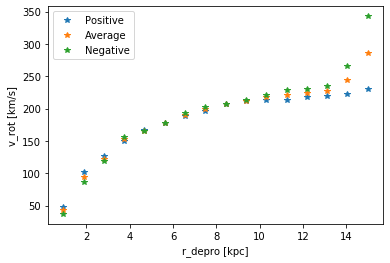

In [52]:
plt.plot(r_dep,max_vel,'*',label = 'Positive')
plt.plot(r_dep,ave_vel,'*',label = 'Average')
plt.plot(r_dep,np.abs(min_vel),'*',label = 'Negative')
plt.ylabel('v_rot [km/s]')
plt.xlabel('r_depro [kpc]')
plt.legend()
plt.show

In [53]:
# bulge 
gamma = 3.3308 # unitless
kappa = gamma*ln(10) # unitless

def sigma_b(x,a,b):
    '''
    parameters:
    x (projected radius): The projected rdius  (pc)
    a (central density): The central density of the bulge (M_sol/pc^2)
    b (central radius): The central radius of the bulge (kpc)
    
    return: surface density of the bulge (g/pc^2)
    '''
    return a*np.exp(-1*kappa*((x/(b*1000))**0.25-1)) #M_sol/pc^2
                           
# derivative of sigma with respect to r
def dsdx(x,a,b):
    '''
    parameters:
    x (projected radius): The projected rdius  (pc)
    a (central density): The central density of the bulge (M/pc^2)
    b (central radius): The central radius of the bulge (kpc)
    
    return: derivative of sigma (g/pc^3)
    '''
    return sigma_b(x,a,b)*(-0.25*kappa)*((b*1000)**-0.25)*(x**-0.75) # M_sol/pc^2 \\

# integrand for getting denisty
def density_integrand(x,r,a,b):
    '''
    parameters:
    x (projected radius): The projected rdius  (pc)   
    r (radius): The a distance from the centre (pc)
    a (central density): The central density of the bulge (M/pc^2)
    b (central radius): The central radius of the bulge (kpc)
    
    return: integrand for volume density of the bulge (g/pc^3)
    '''
    return -(1/np.pi)*dsdx(x,a,b)/np.sqrt(x**2-r**2)

def mass_integrand(r,a,b):
    '''
    parameters:
    x (projected radius): The projected rdius  (pc)   
    r (radius): The a distance from the centre (pc)
    a (central density): The central density of the bulge (M/pc^2)
    b (central radius): The central radius of the bulge (kpc)
    
    return: volume density of the bulge
    '''
    vol_den, vol_den_err = inte.quad(density_integrand, r, np.inf, args=(r,a,b))
    return 4*np.pi*vol_den*r**2
    
# getting a velocity
def vel_b(r,a,b):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    a (central density): The central density of the bulge (M/pc^2)
    b (central radius): The central radius of the bulge (kpc)
    
    return: rotational velocity of the bulge (pc/s)
    '''
    r_n = []
    for i in range(len(r)):
        r_n.append(r[i]*1000)
    bulge_mass = np.zeros(len(r_n))
    vel = np.zeros(len(r_n))
    for i in range(len(r_n)):
        bulge_mass[i],err = inte.quad(mass_integrand, 0, r_n[i], args=(a,b)) # kg
        vel[i] = np.sqrt((1.988E30)*bulge_mass[i]*(G/(3.08E16)**3)/r_n[i])*3.08E13 #km/s
    return vel

In [54]:
# disk
# c = sigma_dc
# d = r_d

def integrand_d(r,c,d):
    '''
    parameters:  
    r (radius): The a distance from the centre (pc)
    c (central surface density): The central surface density of the disk (M/pc^2)
    d (radius radius): The central radius of the disk (kpc)
    
    return: integrand for volume density of the disk
    '''
    return 2*np.pi*c*np.exp(-1*(r/(d*1000)))*r 

def mass_d(r,c,d):
    '''
    parameters:  
    r (radius): The a distance from the centre (pc)
    c (central surface density): The central surface density of the disk (M/pc^2)
    d (radius radius): The central radius of the disk (kpc)
    
    return: mass of the disk (g)
    '''
    res = np.zeros_like(r)
    for i, val in enumerate(r):
        y, err = inte.quad(integrand_d, 0, val, args=(c,d))
        res[i] = y
    return res

def vel_d(r,c,d):
    '''
    parameters:  
    r (radius): The a distance from the centre (pc)
    c (central surface density): The central surface density of the disk (M/pc^2)
    d (radius radius): The central radius of the disk (kpc)
    
    return: rotational velocity of the disk (pc/s)
    '''
    r_n = []
    for i in range(len(r)):
        r_n.append(r[i]*1000)
    return np.sqrt((1.988E30)*mass_d(r_n,c,d)*(G/(3.08E16)**3)/r_n)*3.08E13 #km/s

In [55]:
# halo (isothermal)
# e = rho_0_iso
# f = h

def rho_iso(r,e,f):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    e (central density): The central density of the isothermal halo (M/pc^2)
    f (scale radius): The scale radius of the dark matter halo (kpc)
    
    return: volume density of the isothermal halo (g/pc^3)
    '''
    return e/(1 + (r/(f*10**3))**2)

def integrand_h(r,e,f):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    e (central density): The central density of the isothermal halo (M/pc^2)
    f (scale radius): The scale radius of the dark matter halo (kpc)
    
    return: integrand for getting the mass of the isothermal halo 
    '''
    return 4*np.pi*(rho_iso(r,e,f))*r**2

def mass_h(r,e,f):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    e (central density): The central density of the isothermal halo (M/pc^2)
    f (scale radius): The scale radius of the dark matter halo (kpc)
    
    return: mass of the isothermal halo (g)
    '''
    res = np.zeros_like(r)
    for i, val in enumerate(r):
        y, err = inte.quad(integrand_h, 0, val, args=(e,f))
        res[i] = y
    return res

def vel_h(r,e,f):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    e (central density): The central density of the isothermal halo (M/pc^2)
    f (scale radius): The scale radius of the dark matter halo (kpc)
    
    return: rotational velocity of the isothermal halo (pc/s)
    '''
    r_n = []
    for i in range(len(r)):
        r_n.append(r[i]*1000)
    return np.sqrt((1.988E30)*mass_h(r_n,e,f)*(G/(3.08E16)**3)/r_n)*3.08E13 #km/s

In [56]:
def v_co(r,a,b,c,d,e,f):
    '''
    r (radius): The a distance from the centre (pc)
    a (central density): The central density of the bulge (M/pc^2)
    b (central radius): The central radius of the bulge (kpc)
    c (central surface density): The central surface density of the disk (M/pc^2)
    d (radius radius): The central radius of the disk (kpc)
    e (central density): The central density of the isothermal halo (M/pc^2)
    f (scale radius): The scale radius of the dark matter halo (kpc)
    '''
    return np.sqrt((vel_b(r,a,b)**2) + (vel_d(r,c,d)**2) + (vel_h(r,e,f)**2)) #km/s

In [57]:
r_dep_list = []
for i in range(len(r_dep)):
    r_dep_list.append(r_dep[i])
r_dep_list

[0.9370806777150392,
 1.8741613554300784,
 2.811242033145118,
 3.748322710860157,
 4.685403388575196,
 5.622484066290236,
 6.559564744005274,
 7.496645421720314,
 8.433726099435352,
 9.370806777150392,
 10.307887454865432,
 11.244968132580471,
 12.18204881029551,
 13.119129488010548,
 14.056210165725588,
 14.993290843440628]

In [58]:
ave_vel_list = []
for i in range(len(ave_vel)):
    ave_vel_list.append(ave_vel[i])
ave_vel_list

[42.645312547800984,
 93.88294797331156,
 122.45516223250463,
 152.7845340963127,
 166.10281254600582,
 178.47296066120862,
 190.89198973923132,
 199.41820037113814,
 206.8789285066687,
 212.10783067411,
 217.24212493308977,
 221.51373903437224,
 224.0150922963021,
 227.47014293491856,
 243.76273796174223,
 286.6480923023975]

In [ ]:
popt, pcov = curve_fit(v_co, r_dep_list, ave_vel_list, bounds=(0,np.inf))
plt.plot(r_dep_list, ave_vel_list,label='data')
plt.plot(r_dep_list, v_co(r_dep_list, *popt), label='fit: a=%.2f, b=%.2f, c=%.2f, d=%.2f, e=%.2f, f=%.2f' % tuple(popt))
plt.legend()
plt.show()

/Users/richardzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/richardzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
